# ⚖️ **AdamW, Ranger, and LION — Modern SOTA Optimizers**

This notebook explores **modern state-of-the-art optimizers** and design patterns commonly used in deep learning:

- **AdamW** — Adam with *decoupled weight decay* (fixes L2/weight decay mismatch in Adam).  
- **Ranger / Ranger21** — a practical, composable optimizer family combining RAdam, Lookahead, and other techniques (Ranger21 is a later, more feature-rich variant). 
- **LION** — an optimizer discovered by a symbolic search (Evolved Sign Momentum); simple sign-based update that can outperform Adam variants in some settings. 

This notebook:
- Explains the **mathematical idea** behind each method.
- Implements **simple, pedagogical** versions of each optimizer.
- Visualizes **optimization trajectories**, **loss vs iterations**, and **parameter-step behavior**.
- Quotes the original papers and repositories for further reading.

---

## References (key)
- Loshchilov & Hutter — *Decoupled Weight Decay Regularization* (AdamW). 
- Wright — *Ranger / Ranger21* (RAdam + Lookahead + other enhancements).   
- Chen et al. — *Symbolic Discovery of Optimization Algorithms* (introducing LION).  
- Community implementations and notes (LucidRains LION, Ranger repos). 

These will guide the conceptual notes and the simplified pedagogical implementations below.

## AdamW: Motivation and Mathematics

**Problem:** In adaptive optimizers like Adam, naïvely applying L2 regularization by adding `λ/2 ||w||^2` to the loss is **not equivalent** to explicit multiplicative weight decay in the parameter update — because Adam rescales gradients per-parameter. This mismatch changes the effective regularization and interacts with learning rates in unintuitive ways. 

**Fix (AdamW):** *Decouple* weight decay from the gradient-based parameter update. Concretely, for parameter $ \theta $:

Standard Adam-style step (without weight decay):
$$
\theta \leftarrow \theta - \eta \,\frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon}
$$

AdamW adds a separate decay term:
$$
\theta \leftarrow \theta - \eta \,\frac{\hat{m}}{\sqrt{\hat{v}} + \epsilon} - \eta \, \lambda \, \theta
$$

This decoupling empirically improves generalization and makes the weight-decay hyperparameter more interpretable and independent from the learning rate. 

## Ranger: RAdam + Lookahead (and more)

**Ranger** is a practical combination of recent techniques packaged to be highly usable:

- **RAdam (Rectified Adam):** attempts to fix the variance of Adam's adaptive step in early training by rectifying the adaptive denominator, improving stability.  
- **Lookahead:** maintains a "fast weights" (inner optimizer) and a "slow weights" which are periodically updated towards the fast weights (averaging/consensus) — this stabilizes and improves convergence.  
- Ranger and Ranger21 combine RAdam with Lookahead and additional heuristics (GC, gradient normalization, caching, schedulers) for practical deep learning improvements. 
We'll implement a *simplified* RAdam + Lookahead composition to demonstrate the effect visually.

## LION: Sign-based Momentum (Evolved Sign Momentum)

**LION** (Evolved Sign Momentum) was discovered via symbolic search as a surprisingly simple and effective optimizer. Key ideas:

- Use a momentum-like accumulator but apply updates using the **sign** of a correction term rather than scaled magnitudes.
- Memory-efficient: typically maintains only momentum (no second moment like Adam), making it lighter than Adam while producing competitive performance in some settings. :contentReference[oaicite:10]{index=10}

A canonical LION-style update (simplified):
$$
m_t = \beta m_{t-1} + (1-\beta) g_t
$$
$$
\theta_{t+1} = \theta_t - \eta \,\text{sign}\big( m_t + \alpha g_t \big)
$$

The sign operation reduces sensitivity to per-parameter magnitude differences and often stabilizes training.

### Step-1: Imports and Environment Setup

In [14]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

### Step-2: Define the Sample Function and its Gradient

In [15]:
# We'll use a slightly non-convex test surface to make behavior interesting:
# A smoothed Rosenbrock-like surface plus a small sinusoidal component.
def f(x, y):
    # Rosenbrock-ish
    a = 1.0
    b = 5.0
    rosen = (a - x)**2 + b * (y - x**2)**2
    # add mild ripples
    ripple = 0.1 * np.sin(3.0 * x) * np.cos(3.0 * y)
    return rosen + ripple

def grad_f(x, y, eps=1e-6):
    # numerical gradient (stable, simple)
    h = 1e-6
    fx = f(x + h, y)
    fxm = f(x - h, y)
    fy = f(x, y + h)
    fym = f(x, y - h)
    dfdx = (fx - fxm) / (2*h)
    dfdy = (fy - fym) / (2*h)
    return np.array([dfdx, dfdy])


### Step-3: Helper Function for Plotting Utility

In [16]:
def make_mesh(bounds=(-2, 2), n=400):
    xs = np.linspace(bounds[0], bounds[1], n)
    ys = np.linspace(bounds[0], bounds[1], n)
    X, Y = np.meshgrid(xs, ys)
    Z = f(X, Y)
    return X, Y, Z

X, Y, Z = make_mesh(bounds=(-2.0, 2.0), n=300)

def plot_contour_and_paths(paths, labels, title=""):
    plt.figure(figsize=(8,7))
    plt.contour(X, Y, Z, levels=40, cmap='viridis')
    for p, lab in zip(paths, labels):
        plt.plot(p[:,0], p[:,1], '-o', markersize=3, label=lab)
    plt.scatter(0, 0, marker='*', s=100, c='k', label='Origin (ref)')
    plt.title(title)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.legend()
    plt.show()

### Step-4: AdamW Implementation

In [17]:
def adamw(grad_fn, start, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=1e-3, n_iter=200):
    x = start.astype(float).copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    path = [x.copy()]
    for t in range(1, n_iter+1):
        g = grad_fn(x[0], x[1])
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        step = lr * m_hat / (np.sqrt(v_hat) + eps)
        # decoupled weight decay
        x = x - step - lr * weight_decay * x
        path.append(x.copy())
    return np.array(path)

### Step-5: Simple RAdam (Rectified-ADAM) Implementation

In [18]:
# This is a pedagogical RAdam-like rectification: we approximate the rectification factor.
# It's not an exact production RAdam but demonstrates the early warm-up behavior.
def radam_step(m, v, beta2, t, lr, eps):
    # approximate rectification factor: simple heuristic for demonstration
    rho_inf = 2 / (1 - beta2) - 1
    rho_t = rho_inf - 2 * t * (beta2**t) / (1 - beta2**t + 1e-16)
    if rho_t > 5:
        r_t = np.sqrt((rho_t - 4) * (rho_t - 2) * rho_inf / ((rho_inf - 4) * (rho_inf - 2) * rho_t))
        return r_t
    else:
        return 1.0  # fall back to non-rectified

### Step-6: LookAhead Wrapper Function

In [19]:
def lookahead(inner_optimizer_fn, lookahead_k=5, alpha=0.5):
    # Returns a function that runs the inner optimizer for `k` steps and then pulls slow weights toward fast.
    def wrapped(grad_fn, start, **kwargs):
        x_slow = start.astype(float).copy()
        x_fast = x_slow.copy()
        path = [x_slow.copy()]
        n_total = kwargs.get("n_iter", 100)
        step = 0
        while step < n_total:
            # run inner optimizer for up to lookahead_k steps (or remaining)
            inner_steps = min(lookahead_k, n_total - step)
            # call inner optimizer to produce inner_steps steps starting from x_fast
            inner_path = inner_optimizer_fn(grad_fn, x_fast.copy(), n_iter=inner_steps, **kwargs)
            x_fast = inner_path[-1].copy()
            # update slow weights
            x_slow = x_slow + alpha * (x_fast - x_slow)
            x_fast = x_slow.copy()
            path.append(x_slow.copy())
            step += inner_steps
        return np.array(path)
    return wrapped

### Step-7: Simplified Ranger (RAdam+Lookahead) Implementation

In [20]:
def simple_radam(grad_fn, start, lr=0.01, beta1=0.9, beta2=0.999, eps=1e-8, weight_decay=0.0, n_iter=200):
    x = start.astype(float).copy()
    m = np.zeros_like(x)
    v = np.zeros_like(x)
    path = [x.copy()]
    for t in range(1, n_iter+1):
        g = grad_fn(x[0], x[1])
        m = beta1 * m + (1 - beta1) * g
        v = beta2 * v + (1 - beta2) * (g * g)
        r = radam_step(m, v, beta2, t, lr, eps)
        m_hat = m / (1 - beta1**t)
        v_hat = v / (1 - beta2**t)
        step = lr * r * m_hat / (np.sqrt(v_hat) + eps)
        x = x - step - lr * weight_decay * x
        path.append(x.copy())
    return np.array(path)

# Compose a lookahead wrapper with simple_radam
simple_ranger = lookahead(simple_radam, lookahead_k=5, alpha=0.5)

### Step-8: LION Implementation

In [21]:
def lion(grad_fn, start, lr=0.01, beta=0.9, alpha=0.0, n_iter=200):
    # Simplified LION: momentum + sign update (pedagogical)
    x = start.astype(float).copy()
    m = np.zeros_like(x)
    path = [x.copy()]
    for t in range(1, n_iter+1):
        g = grad_fn(x[0], x[1])
        m = beta * m + (1 - beta) * g
        # combine momentum and current gradient (alpha weight)
        update = m + alpha * g
        x = x - lr * np.sign(update)
        path.append(x.copy())
    return np.array(path)

### Step-9: Run and Collect Paths

In [26]:
start = np.array([1.6, 1.2])

# run optimizers
n_iter = 200
path_adamw = adamw(grad_f, start, lr=0.01, weight_decay=1e-3)
path_ranger = simple_ranger(grad_f, start, lr=0.02)
path_lion = lion(grad_f, start, lr=0.01, beta=0.9, alpha=0.01)

### Step-10: Trajectory Contour Plot

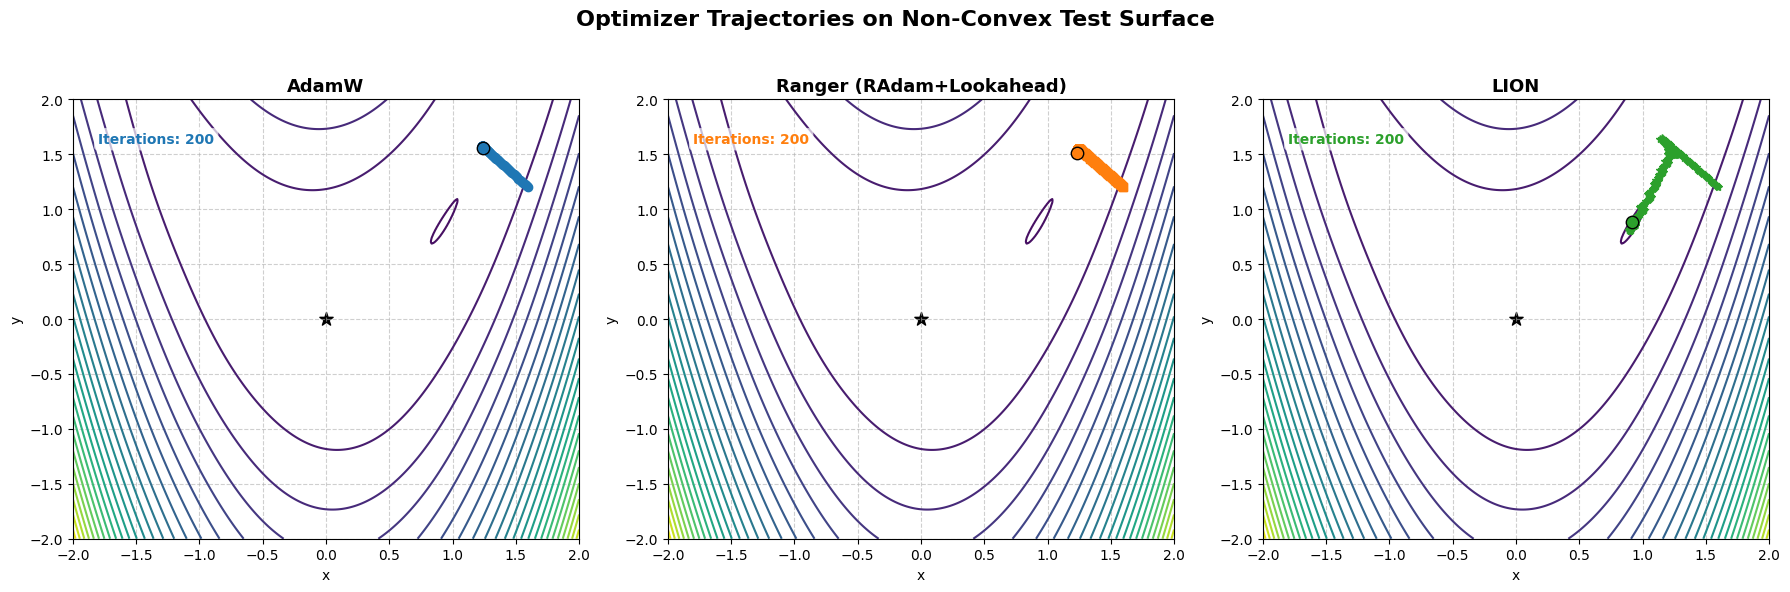

In [30]:
# For Ranger (which returns fewer points due to lookahead composition), we upsample for plotting consistency.
def expand_path(p):
    if p.shape[0] > n_iter:
        return p[:n_iter+1]
    # If lookahead produced fewer points, interpolate linearly for visualization
    t = np.linspace(0, 1, n_iter+1)
    idx = np.linspace(0, 1, p.shape[0])
    x_interp = np.interp(t, idx, p[:, 0])
    y_interp = np.interp(t, idx, p[:, 1])
    return np.vstack([x_interp, y_interp]).T


ranger_path_expanded = expand_path(path_ranger)

# Define optimizers and visuals
optimizers = ["AdamW", "Ranger (RAdam+Lookahead)", "LION"]
paths = [path_adamw, ranger_path_expanded, path_lion]
colors = ['tab:blue', 'tab:orange', 'tab:green']
markers = ['o', 's', '*']

# Create figure and 1x3 subplots
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

for ax, name, path, color, marker in zip(axes, optimizers, paths, colors, markers):
    # Draw contour surface
    ax.contour(X, Y, Z, levels=25, cmap='viridis')
    
    # Plot optimizer trajectory
    ax.plot(
        path[:, 0],
        path[:, 1],
        color=color,
        marker=marker,
        markersize=6,
        linewidth=1.8,
        label=name
    )
    
    # Mark global minimum
    ax.scatter(0, 0, c='black', marker='*', s=100)
    
    # Highlight final convergence point
    ax.scatter(
        path[-1, 0], path[-1, 1],
        color=color, edgecolors='k', s=80, zorder=5
    )
    
    # Annotate iteration count
    ax.text(
        0.05, 0.9,
        f"Iterations: {len(path)-1}",
        transform=ax.transAxes,
        fontsize=10,
        color=color,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', boxstyle='round,pad=0.3')
    )

    # Titles, labels, and style
    ax.set_title(name, fontsize=13, weight='bold')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.grid(True, linestyle='--', alpha=0.6)

# Overall title and layout
plt.suptitle("Optimizer Trajectories on Non-Convex Test Surface", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

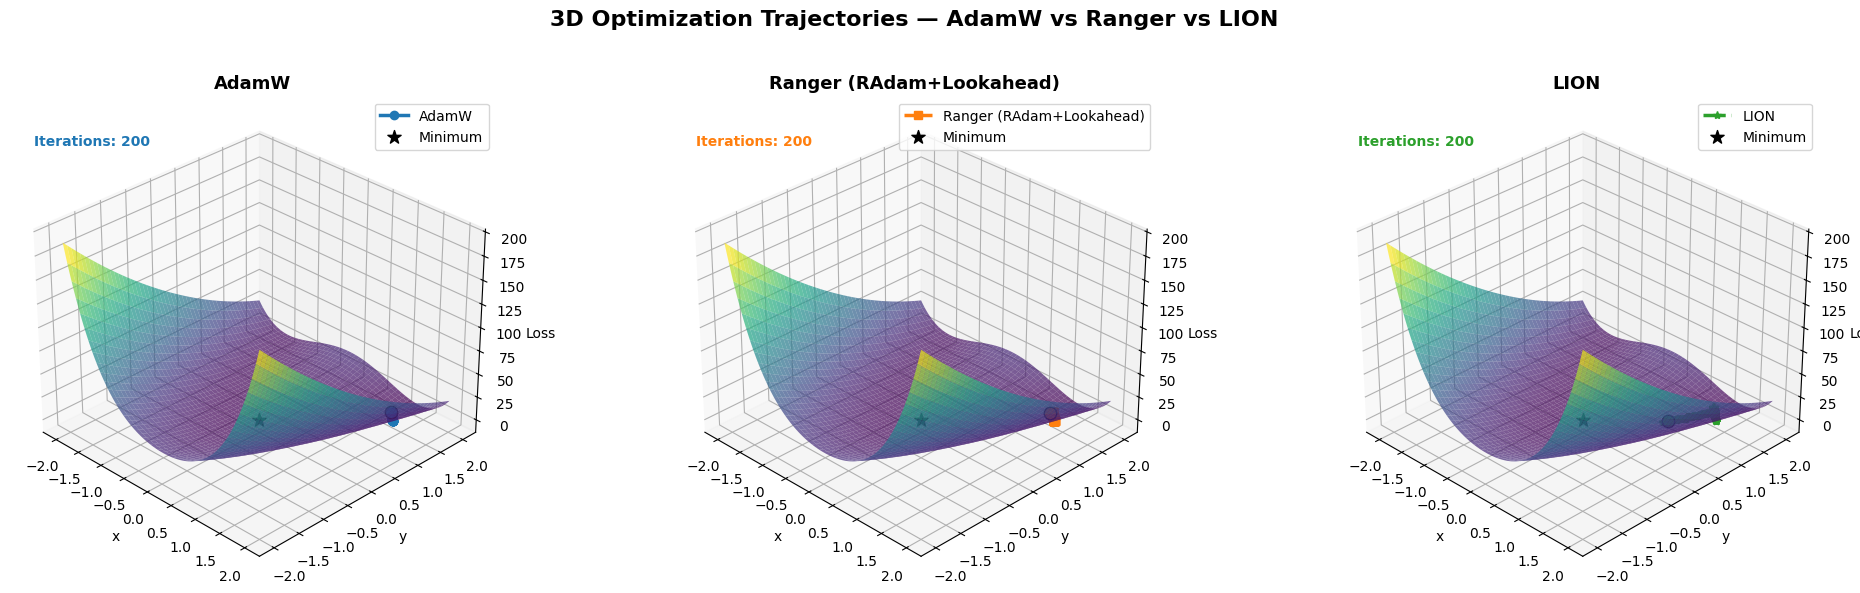

In [ ]:
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm

# Assuming you already have: X, Y, Z, f(), path_adamw, path_ranger, path_lion

# Prepare optimizer info
optimizers = ["AdamW", "Ranger (RAdam+Lookahead)", "LION"]
paths = [path_adamw, ranger_path_expanded, path_lion]
colors = ['tab:blue', 'tab:orange', 'tab:green']
linestyles = ['-', '--', '-.']
markers = ['o', 's', '*']

# Create 1×3 subplot grid for 3D plots
fig = plt.figure(figsize=(20, 6))

for i, (name, path, color, ls, marker) in enumerate(zip(optimizers, paths, colors, linestyles, markers), 1):
    ax = fig.add_subplot(1, 3, i, projection='3d')
    
    # Plot surface
    ax.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.7, linewidth=0, antialiased=True)
    
    # Plot optimizer path
    ax.plot(
        path[:, 0],
        path[:, 1],
        f(path[:, 0], path[:, 1]),
        color=color,
        linestyle=ls,
        marker=marker,
        markersize=6,
        linewidth=2.5,
        label=name
    )

    # Highlight final point
    ax.scatter(
        path[-1, 0],
        path[-1, 1],
        f(path[-1, 0], path[-1, 1]),
        c=color,
        edgecolors='k',
        s=80,
        zorder=5
    )

    # Mark global minimum
    ax.scatter(0, 0, 0, c='black', marker='*', s=100, label='Minimum')

    # Annotate iteration count
    ax.text2D(
        0.05, 0.9,
        f"Iterations: {len(path)-1}",
        transform=ax.transAxes,
        fontsize=10,
        color=color,
        weight='bold',
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.3')
    )

    # Titles and labels
    ax.set_title(name, fontsize=13, weight='bold')
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("Loss")
    ax.view_init(elev=30, azim=-45)
    ax.legend()

# Global figure title
plt.suptitle("3D Optimization Trajectories — AdamW vs Ranger vs LION", fontsize=16, weight='bold')
plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

### Step-11: Study Loss against Iterations

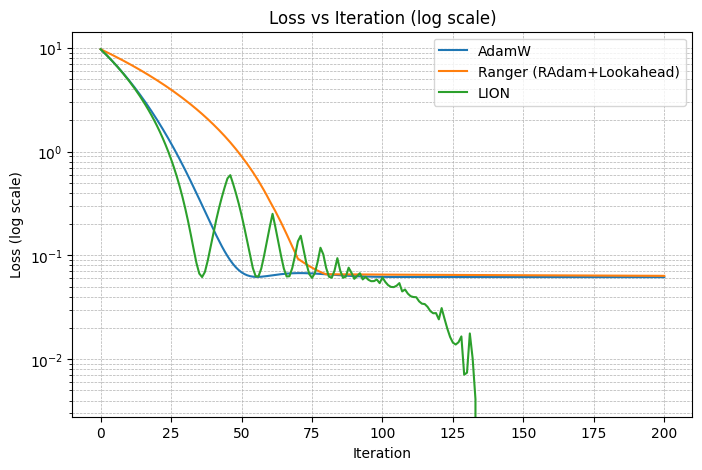

In [33]:
def compute_loss_path(path):
    return np.array([f(p[0], p[1]) for p in path])

loss_adamw = compute_loss_path(path_adamw)
loss_ranger = compute_loss_path(ranger_path_expanded)
loss_lion = compute_loss_path(path_lion)

plt.figure(figsize=(8,5))
plt.plot(loss_adamw, label='AdamW')
plt.plot(loss_ranger, label='Ranger (RAdam+Lookahead)')
plt.plot(loss_lion, label='LION')
plt.yscale('log')
plt.xlabel("Iteration")
plt.ylabel("Loss (log scale)")
plt.title("Loss vs Iteration (log scale)")
plt.legend()
plt.grid(True, which="both", ls="--", linewidth=0.5)
plt.show()

### Step-12: 3D Trajectory Visualizations

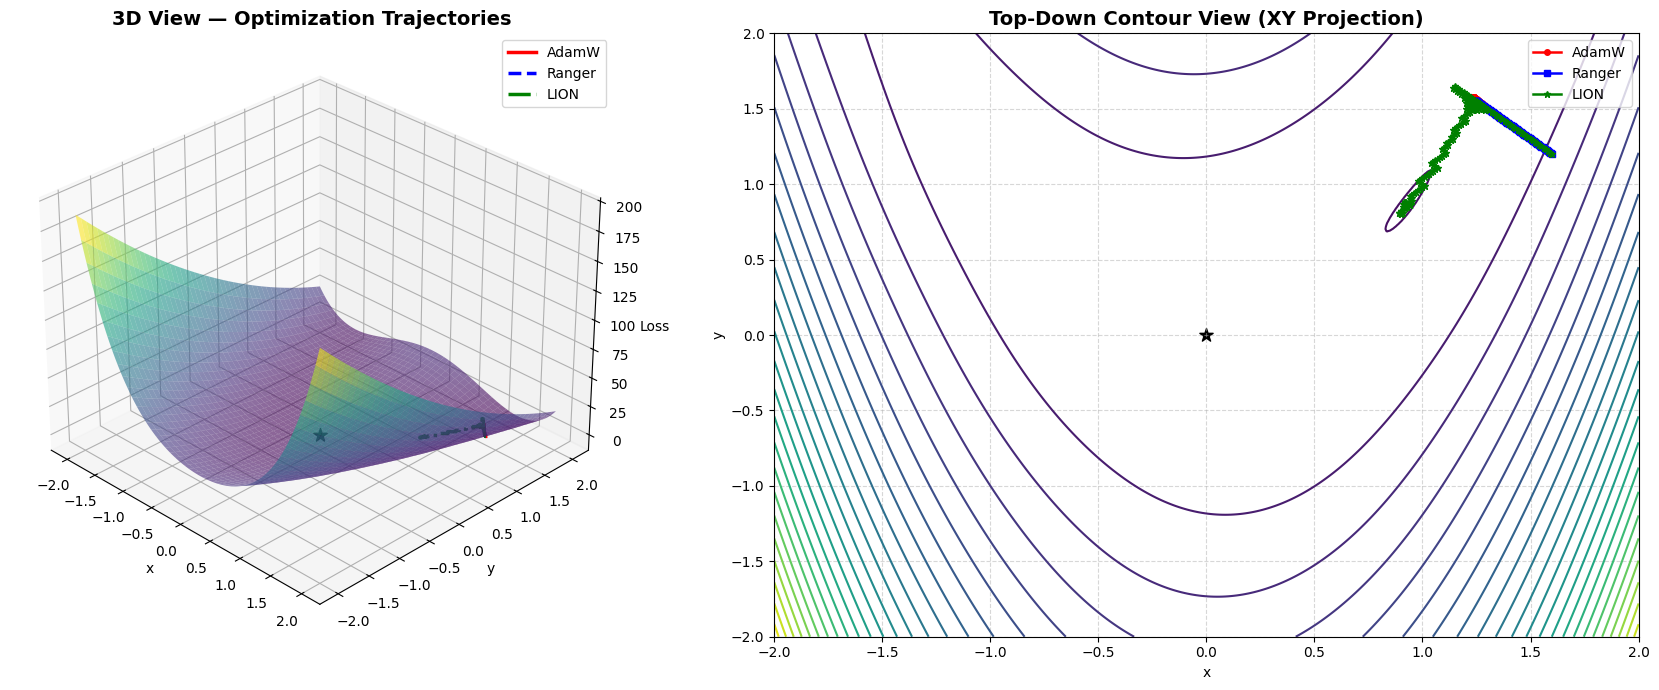

In [40]:
fig = plt.figure(figsize=(18, 7))

# ----------------- 3D VIEW -----------------
ax1 = fig.add_subplot(1, 2, 1, projection='3d')
ax1.plot_surface(X, Y, Z, cmap=cm.viridis, alpha=0.6, linewidth=0, antialiased=True)

# Optimizer trajectories (3D)
ax1.plot(path_adamw[:,0], path_adamw[:,1], compute_loss_path(path_adamw),
         'r-', linewidth=2.5, label='AdamW')
ax1.plot(ranger_path_expanded[:,0], ranger_path_expanded[:,1], compute_loss_path(ranger_path_expanded),
         'b--', linewidth=2.5, label='Ranger')
ax1.plot(path_lion[:,0], path_lion[:,1], compute_loss_path(path_lion),
         'g-.', linewidth=2.5, label='LION')

# Minimum point
ax1.scatter(0, 0, 0, c='black', marker='*', s=100)

# Labels & styling
ax1.set_title("3D View — Optimization Trajectories", fontsize=14, weight='bold')
ax1.set_xlabel("x")
ax1.set_ylabel("y")
ax1.set_zlabel("Loss")
ax1.legend()
ax1.view_init(elev=30, azim=-45)   # nice angle

# ----------------- TOP VIEW -----------------
ax2 = fig.add_subplot(1, 2, 2)
ax2.contour(X, Y, Z, levels=25, cmap='viridis')

# Plot flattened optimizer paths (same xy, color)
ax2.plot(path_adamw[:,0], path_adamw[:,1], 'r-o', markersize=4, linewidth=1.8, label='AdamW')
ax2.plot(ranger_path_expanded[:,0], ranger_path_expanded[:,1], 'b-s', markersize=4, linewidth=1.8, label='Ranger')
ax2.plot(path_lion[:,0], path_lion[:,1], 'g-*', markersize=5, linewidth=1.8, label='LION')

# Mark the global minimum
ax2.scatter(0, 0, c='black', marker='*', s=100)
ax2.set_title("Top-Down Contour View (XY Projection)", fontsize=14, weight='bold')
ax2.set_xlabel("x")
ax2.set_ylabel("y")
ax2.legend()
ax2.grid(True, linestyle='--', alpha=0.5)

# plt.plot(loss_adamw, 'o-', label='AdamW', linewidth=2, markersize=4)
# plt.plot(loss_ranger, 's--', label='Ranger', linewidth=2, markersize=4)
# plt.plot(loss_lion, 'd-.', label='LION', linewidth=2, markersize=4)


# Adjust layout
# plt.yticks([1e-5, 1e-4, 1e-3, 1e-2, 1e-1, 1, 10])
# plt.ylim(ymin * 0.3, ymax * 3.0)
plt.tight_layout()
plt.show()


### Step-13: Effective Step-size / Per-parameter behavior

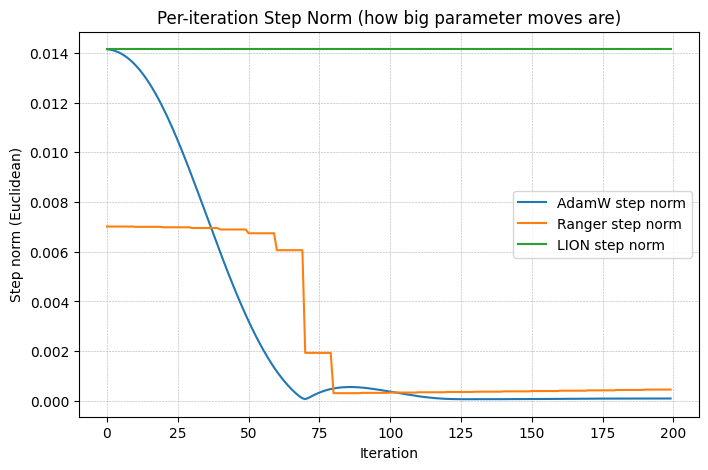

In [41]:
# Visualize effective step sizes (norm of parameter change) per iteration
step_adamw = np.linalg.norm(np.diff(path_adamw, axis=0), axis=1)
step_ranger = np.linalg.norm(np.diff(ranger_path_expanded, axis=0), axis=1)
step_lion = np.linalg.norm(np.diff(path_lion, axis=0), axis=1)

plt.figure(figsize=(8,5))
plt.plot(step_adamw, label='AdamW step norm')
plt.plot(step_ranger, label='Ranger step norm')
plt.plot(step_lion, label='LION step norm')
plt.xlabel("Iteration")
plt.ylabel("Step norm (Euclidean)")
plt.title("Per-iteration Step Norm (how big parameter moves are)")
plt.legend()
plt.grid(True, ls='--', linewidth=0.4)
plt.show()

## Observations & Practical Notes

- **AdamW**: decoupled weight decay makes regularization more consistent across optimizers and hyperparameter choices; here AdamW shows steady, smooth descent and good early progress.
- **Ranger**: the combination of rectified adaptive steps (RAdam) and Lookahead often produces **more stable early dynamics** and better final convergence in practice; the lookahead averaging reduces oscillations. The Ranger family (and Ranger21) collects many practical heuristics geared toward real training pipelines. 
- **LION**: sign-based updates produce relatively consistent step norms (because sign-based updates ignore magnitude differences), which can be beneficial in some scaling regimes and memory-constrained contexts. LION’s simplicity (momentum + sign) gives it attractive computational and memory trade-offs. 

### Practical advice
- Tune **learning rate** jointly with **weight decay** for AdamW; decoupling helps but choice still matters. 
- Use Lookahead (or Ranger) when training is unstable or when you observe oscillations. 
- LION can be a strong alternative to AdamW for large-scale models — experiment with sign-based updates and momentum coefficients.

## Further Reading & Implementation Links

- Loshchilov & Hutter — *Decoupled Weight Decay Regularization* (AdamW). 
- Ranger repository & Ranger21: practical implementations and Ranger21 paper.  
- Chen et al. — *Symbolic Discovery of Optimization Algorithms* (introducing LION).   
- LION community implementations (e.g., lucidrains). 

Use these sources to expand the simplified implementations here into highly-tuned, production-ready optimizer code for deep learning frameworks (PyTorch, JAX, TensorFlow).

# ✅ Summary

- AdamW provides a principled fix to weight decay in adaptive optimizers; decoupling improves interpretability and often generalization.
- Ranger (and Ranger21) are pragmatic, assembler-like approaches that combine multiple improvements (RAdam, Lookahead, gradient-centralization, etc.) to yield robust training behavior.   
- LION shows that simple sign-based momentum rules discovered by symbolic methods can outperform heavier optimizers in practice under some settings. 

---